In [4]:
import sys
import os
import importlib
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

In [5]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [6]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

/scratch/local/jobs/3862660/ipykernel_3830995/1819589819.py:20: UserWarning: Trying to register the cmap 'diverging' which already exists.
  mpl.colormaps.register(cm_div, force=True)


# Load Data

In [7]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [8]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [9]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [10]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [11]:
# load committors
q = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns
w = np.load(
    "../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[0]

In [12]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)

In [17]:
X = np.hstack((cv_arr, sb_arr, rf161_arr))
y = np.concatenate(q)
print(X.shape, y.shape)

(4150115, 65) (4150115,)


In [34]:
feature_names = []
feature_names.append('Translocation')
feature_names.append('Rotation')
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        feature_names.append(f"{r} C$_\\alpha$—{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$—{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$—{n} C$_\\varepsilon$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}—F161")

# regression

In [15]:
from sklearn.linear_model import Lasso

In [21]:
def run_lasso(data, q, alpha=0.1, fit_intercept=True):
    model = Lasso(alpha=alpha, fit_intercept=False)
    model.fit(data, q)
    recon = model.predict(data)
    beta = model.coef_
    intercept = model.intercept_
    score = model.score(data, q)
    return recon, beta, intercept, score

## all data

In [21]:
cutoff = 0.01

In [30]:
# sigmoid transform
idx = ((y > cutoff) & (y < 1 - cutoff))
logit_q = np.log(y[idx] / (1 - y[idx]))
recon, coeffs, intercept, r2 = run_lasso(X[idx, :], logit_q)

In [31]:
print(coeffs, intercept, r2)

[ 0.05436572  0.03013265 -0.          0.         -0.          0.
  0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.48603475  0.
  0.          0.72026071 -0.          0.         -0.         -0.08398099
  0.          0.         -0.          0.         -0.         -0.
 -0.         -0.5303037 ] 0.7814061459110504 0.8428657079194404


<BarContainer object of 62 artists>

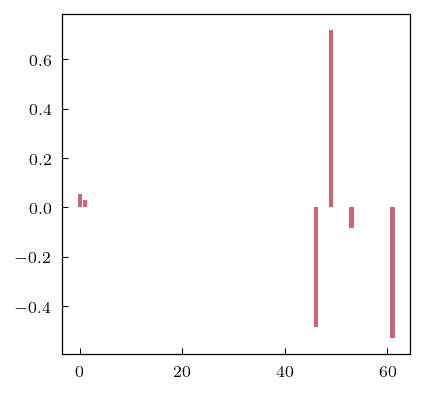

In [32]:
plt.bar(np.arange(62), coeffs)

In [54]:
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

Translocation: 0.0747364029135267
Rotation: 0.040916314404836694
R226 C$_\zeta$$—D151 C$_\gamma$: -0.3642527251843671
R226 C$_\zeta$$—D186 C$_\gamma$: 0.20115604567122872
R232 C$_\zeta$$—D186 C$_\gamma$: -0.19507644263967994


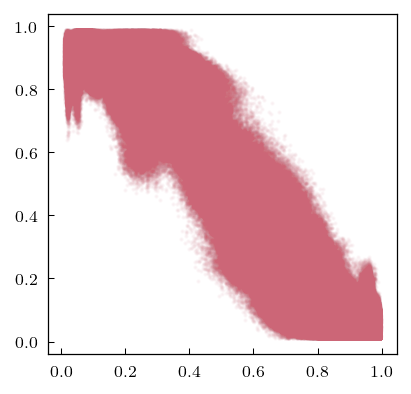

In [46]:
pred_q = 1.0 / (1.0 + np.exp(recon))
pplt.plot(pred_q, y[idx], '.', alpha=0.05)

In [48]:
# try varying values of alpha
for a in np.linspace(0.02, 0.12, 6):
    _, coeffs, intercept, r2 = run_lasso(X[idx, :], logit_q, alpha=a)
    print(coeffs, intercept, r2)

[-0.01093659  0.00305863 -0.22954503 -0.         -0.         -0.
  0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.          0.          0.          0.
 -0.         -0.         -0.08163638 -0.         -0.         -0.
  0.          0.          1.3411123  -0.         -0.          0.
  0.          0.         -0.         -0.         -0.73416051  0.55353013
  0.          0.77175484 -0.62315237  0.          0.         -0.93123544
  0.          0.          0.          0.53054395  0.          0.
 -0.07671037 -0.79627028] 0.12652329071451907 0.9335326426637172
[-0.          0.01035443 -0.          0.         -0.         -0.
  0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.          0.         -0.         -0.
  0.     

In [53]:
# try varying values of alpha
for a in np.linspace(0.11, 0.15, 5):
    _, coeffs, intercept, r2 = run_lasso(X[idx, :], logit_q, alpha=a)
    print(coeffs, intercept, r2)

[ 0.05533158  0.0323418  -0.          0.         -0.          0.
  0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.49277976  0.
  0.          0.60015851 -0.          0.         -0.         -0.02556213
  0.          0.         -0.          0.         -0.         -0.
 -0.         -0.48425969] 0.8467594782812219 0.8337969813760486
[ 0.05875106  0.03450921 -0.          0.         -0.          0.
  0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.          0.         -0.         -0.
  0.          0.         -0.          0.         -0.         -0.
  0.         -0.  

## Subset $q_+\in (0.2, 0.8)$

In [55]:
cutoff = 0.2
# sigmoid transform
idx = ((y > cutoff) & (y < 1 - cutoff))
logit_q = np.log(y[idx] / (1 - y[idx]))
for a in np.linspace(0.02, 0.20, 10):
    print(a)
    _, coeffs, intercept, r2 = run_lasso(X[idx, :], logit_q, alpha=a)
    print(coeffs, intercept, r2)

0.02
[ 0.0954408   0.01179423  0.          0.          0.          0.
  0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.          0.         -0.         -0.
  0.          0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.          0.          0.          0.          0.
  0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.39880021  0.
  0.          0.54131986 -0.         -0.         -0.         -0.37399793
 -0.         -0.         -0.          0.         -0.         -0.021686
 -0.10442282 -0.53752603] 1.0637966747437608 0.8632054797388787
0.04000000000000001
[ 0.10500123  0.01628659  0.          0.         -0.          0.
  0.          0.         -0.          0.         -0.         -0.
  0.          0.         -0.          0.         -0.         -0.
  0.          0.         -0.          0.         -0.

In [56]:
pred, coeffs, intercept, r2 = run_lasso(X[idx, :], logit_q, alpha=0.04)

<BarContainer object of 62 artists>

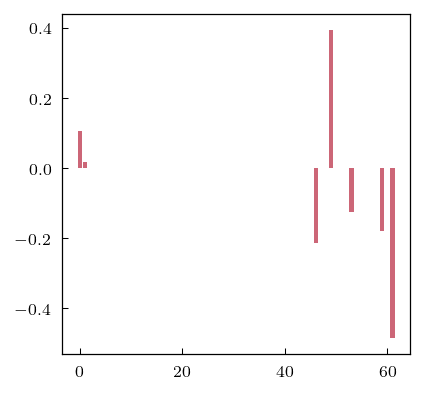

In [57]:
plt.bar(np.arange(62), coeffs)

In [58]:
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

Translocation: 0.10500123114477958
Rotation: 0.016286594515824388
R226 C$_\zeta$$—D151 C$_\gamma$: -0.21328356144056793
R226 C$_\zeta$$—D186 C$_\gamma$: 0.3949667273706955
R229 C$_\zeta$$—D164 C$_\gamma$: -0.12630756835270696
R232 C$_\zeta$$—D164 C$_\gamma$: -0.1794287355605415
R232 C$_\zeta$$—D186 C$_\gamma$: -0.48599406316629995


Translocation: 0.11028576056914083
Rotation: 0.018296639705385406
R226 C$_\zeta$$—D151 C$_\gamma$: -0.09495950232328433
R226 C$_\zeta$$—D186 C$_\gamma$: 0.36591655700354014
R232 C$_\zeta$$—D164 C$_\gamma$: -0.23941739309153706
R232 C$_\zeta$$—D186 C$_\gamma$: -0.4247109552743006


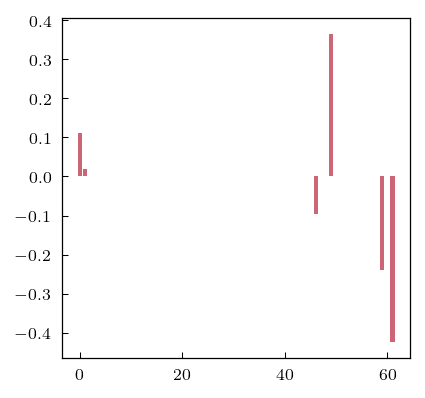

In [59]:
pred, coeffs, intercept, r2 = run_lasso(X[idx, :], logit_q, alpha=0.05)
plt.bar(np.arange(62), coeffs)
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

Translocation: 0.11858804241550222
Rotation: 0.019960838881603438
R226 C$_\zeta$$—D186 C$_\gamma$: 0.32303631085399676
R232 C$_\zeta$$—D164 C$_\gamma$: -0.23050346518386744
R232 C$_\zeta$$—D186 C$_\gamma$: -0.36756549166822117


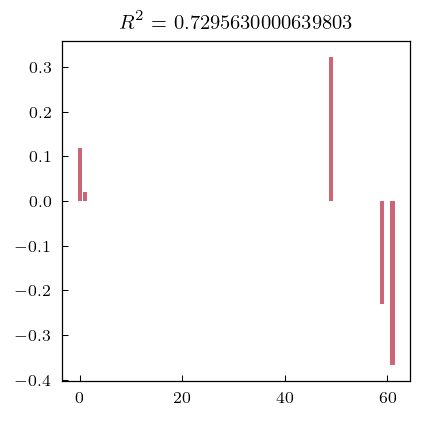

In [60]:
pred, coeffs, intercept, r2 = run_lasso(X[idx, :], logit_q, alpha=0.06)
plt.bar(np.arange(62), coeffs)
plt.title(f"$R^2$ = {r2}")
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

## Subset with weighting to transition state

In [68]:
np.random.seed(123)

In [69]:
w_arr = np.concatenate(w)
cutoff = 0.2
nsamp = 1000000
# sigmoid transform
mid_idx = ((y > cutoff) & (y < 1 - cutoff)).nonzero()[0]
weights = w_arr[mid_idx] * y[mid_idx] * (1 - y[mid_idx])
weights /= np.sum(weights)
idx = np.random.choice(mid_idx, size=min(nsamp,len(mid_idx)), p=weights, replace=False)
logit_q = np.log(y[idx] / (1 - y[idx]))

In [70]:
for a in np.linspace(0.02, 0.20, 10):
    print(f"{a:.2f}")
    _, coeffs, intercept, r2 = run_lasso(X[idx, :], logit_q, alpha=a)
    print(f"Coeffs: {coeffs}")
    print(f"Intercept: {intercept}")
    print(f"R^2: {r2}")
    print("----------------------")

0.02
Coeffs: [ 0.09731119  0.01183525  0.          0.          0.          0.
  0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.          0.         -0.         -0.
  0.          0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.          0.          0.          0.          0.
  0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.38437387  0.
  0.          0.5294979  -0.         -0.         -0.         -0.3536003
 -0.         -0.         -0.          0.         -0.         -0.04815289
 -0.09900037 -0.51913531]
Intercept: 1.0685000334891868
R^2: 0.8583642635093226
----------------------
0.04
Coeffs: [ 0.10803106  0.0163857   0.          0.         -0.          0.
  0.          0.         -0.          0.         -0.         -0.
  0.          0.         -0.          0.         -0.         -0.
  0.       

Translocation: 0.1229946110639352
Rotation: 0.01998982901121664
R226 C$_\zeta$$—D186 C$_\gamma$: 0.2947671226620535
R232 C$_\zeta$$—D164 C$_\gamma$: -0.24843285024450973
R232 C$_\zeta$$—D186 C$_\gamma$: -0.333361666537624


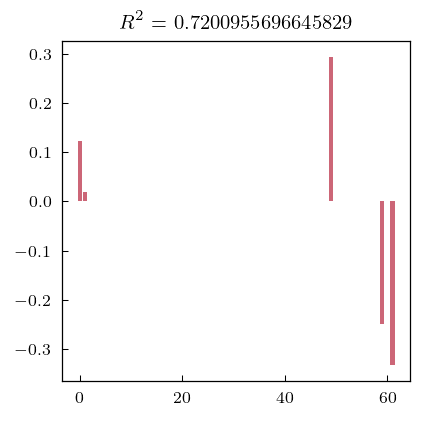

In [71]:
pred, coeffs, intercept, r2 = run_lasso(X[idx, :], logit_q, alpha=0.06)
plt.bar(np.arange(62), coeffs)
plt.title(f"$R^2$ = {r2}")
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

Translocation: 0.11469516810418018
Rotation: 0.018355993647461127
R226 C$_\zeta$$—D151 C$_\gamma$: -0.0448893254371174
R226 C$_\zeta$$—D186 C$_\gamma$: 0.3704214886409751
R232 C$_\zeta$$—D164 C$_\gamma$: -0.2679858653746136
R232 C$_\zeta$$—D186 C$_\gamma$: -0.3854171347369327


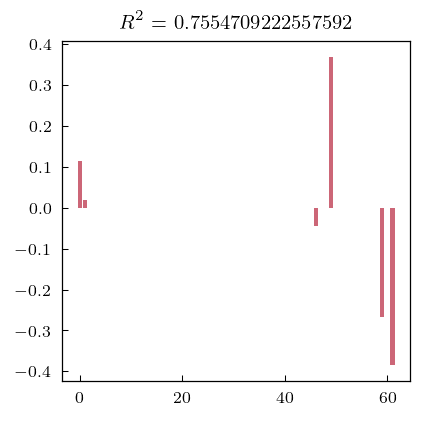

In [72]:
pred, coeffs, intercept, r2 = run_lasso(X[idx, :], logit_q, alpha=0.05)
plt.bar(np.arange(62), coeffs)
plt.title(f"$R^2$ = {r2}")
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

# StandardScaler

In [73]:
w_arr = np.concatenate(w)
cutoff = 0.2
nsamp = 1000000
# sigmoid transform
mid_idx = ((y > cutoff) & (y < 1 - cutoff)).nonzero()[0]
weights = w_arr[mid_idx] * y[mid_idx] * (1 - y[mid_idx])
weights /= np.sum(weights)
idx = np.random.choice(mid_idx, size=min(nsamp,len(mid_idx)), p=weights, replace=False)
logit_q = np.log(y[idx] / (1 - y[idx]))

In [74]:
std_scale = sklearn.preprocessing.StandardScaler()
X_trans = std_scale.fit_transform(X[idx])
pred, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=0.05)

Rotation: 0.012959621071254349
R229 C$_\alpha$$—D129 C$_\alpha$: -0.004449572343491591
R232 C$_\alpha$$—D164 C$_\alpha$: -0.01863012376148254
R232 C$_\alpha$$—D186 C$_\alpha$: -0.12176169960135418
R223 C$_\zeta$$—D164 C$_\gamma$: 0.10781092251245515
R226 C$_\zeta$$—D136 C$_\gamma$: -0.04810702044574488
R226 C$_\zeta$$—D151 C$_\gamma$: -0.10521339744643285
R226 C$_\zeta$$—D164 C$_\gamma$: 0.008350589137402782
R226 C$_\zeta$$—D186 C$_\gamma$: 0.13639383974329639
R229 C$_\zeta$$—D151 C$_\gamma$: -0.029331649804230094
R229 C$_\zeta$$—D164 C$_\gamma$: -0.08211790816264096
R232 C$_\zeta$$—D186 C$_\gamma$: -0.20372435038890965


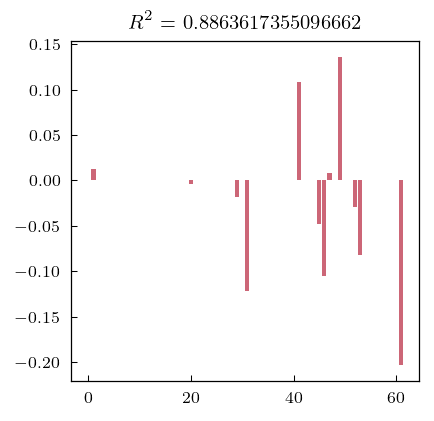

In [75]:
plt.bar(np.arange(62), coeffs)
plt.title(f"$R^2$ = {r2}")
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

In [77]:
for a in np.linspace(0.06, 0.20, 8):
    print(f"{a:.2f}")
    _, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=a)
    print(f"Coeffs: {coeffs}")
    print(f"Intercept: {intercept}")
    print(f"R^2: {r2}")
    print("----------------------")

0.06
Coeffs: [ 0.          0.01137291  0.          0.          0.          0.
  0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.          0.         -0.         -0.02125413
 -0.         -0.11677972  0.          0.          0.          0.
  0.          0.          0.         -0.         -0.          0.09520343
  0.          0.         -0.         -0.04127328 -0.10862157  0.02058358
  0.          0.12825998 -0.         -0.         -0.02911539 -0.07259035
  0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.20386034]
Intercept: -0.22190390033969468
R^2: 0.8805653865019516
----------------------
0.08
Coeffs: [ 0.          0.00623269  0.          0.          0.          0.
  0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.     

## With F161 distances

In [18]:
w_arr = np.concatenate(w)
cutoff = 0.2
nsamp = 1000000
# sigmoid transform
mid_idx = ((y > cutoff) & (y < 1 - cutoff)).nonzero()[0]
weights = w_arr[mid_idx] * y[mid_idx] * (1 - y[mid_idx])
weights /= np.sum(weights)
idx = np.random.choice(mid_idx, size=min(nsamp,len(mid_idx)), p=weights, replace=False)
logit_q = np.log(y[idx] / (1 - y[idx]))

In [19]:
std_scale = sklearn.preprocessing.StandardScaler()
X_trans = std_scale.fit_transform(X[idx])

In [29]:
coeffs_all = []
for a in np.linspace(0.02, 0.30, 15):
    print(f"{a:.2f}")
    _, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=a, fit_intercept=False)
    # print(f"Coeffs: {coeffs}")
    # print(f"Intercept: {intercept}")
    # print(f"R^2: {r2}")
    # print("----------------------")
    coeffs_all.append(coeffs)

0.02
0.04
0.06
0.08
0.10
0.12
0.14
0.16
0.18
0.20
0.22
0.24
0.26
0.28
0.30


R232 C$_\alpha$$—D164 C$_\alpha$: -0.006849109526135455
R232 C$_\alpha$$—D186 C$_\alpha$: -0.08246770110517335
R226 C$_\zeta$$—D151 C$_\gamma$: -0.10274173259008289
R226 C$_\zeta$$—D164 C$_\gamma$: 0.07064182816026625
R226 C$_\zeta$$—D186 C$_\gamma$: 0.1058191650967066
R232 C$_\zeta$$—D186 C$_\gamma$: -0.18145698787870776
R229—F161: -0.08082768654455755


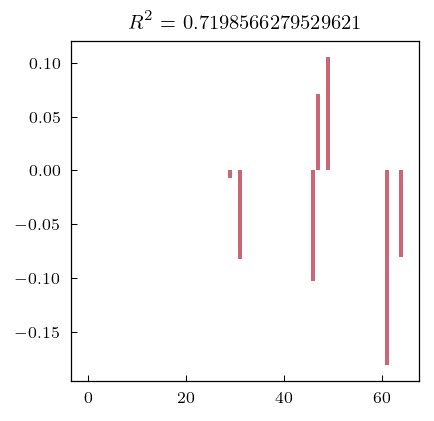

In [28]:
# 0.16 : 7 nonzero coeffs
pred, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=0.16, fit_intercept=False)
plt.bar(np.arange(len(coeffs)), coeffs)
plt.title(f"$R^2$ = {r2}")
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

In [31]:
# plot trajectory of coefficients
for i in coeffs_all[0].nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs_all[0][i]}")

Rotation: 0.02146487304282098
R223 C$_\alpha$$—D186 C$_\alpha$: 0.016964120277458666
R226 C$_\alpha$$—D129 C$_\alpha$: -0.007310541146682099
R229 C$_\alpha$$—D129 C$_\alpha$: -0.021798747124576117
R232 C$_\alpha$$—D164 C$_\alpha$: -0.020064532139473817
R232 C$_\alpha$$—D186 C$_\alpha$: -0.13703658905791735
R217 C$_\zeta$$—D136 C$_\gamma$: 0.0071703683460012865
R217 C$_\zeta$$—D151 C$_\gamma$: 0.020975939535957337
R223 C$_\zeta$$—D129 C$_\gamma$: 0.03214108201530222
R223 C$_\zeta$$—D164 C$_\gamma$: 0.01576409551079444
R223 C$_\zeta$$—D186 C$_\gamma$: 0.0872622251362581
R226 C$_\zeta$$—D129 C$_\gamma$: -0.019150182402517296
R226 C$_\zeta$$—D136 C$_\gamma$: -0.057521672170511906
R226 C$_\zeta$$—D151 C$_\gamma$: -0.11453950922325296
R226 C$_\zeta$$—D186 C$_\gamma$: 0.09589661052125846
R232 C$_\zeta$$—E183 C$_\varepsilon$: -0.05822068229881711
R232 C$_\zeta$$—D186 C$_\gamma$: -0.15914059475415993
R223—F161: 0.014818260679786375
R229—F161: -0.13066956314977238


Text(0, 0.5, 'Coefficients $\\beta$')

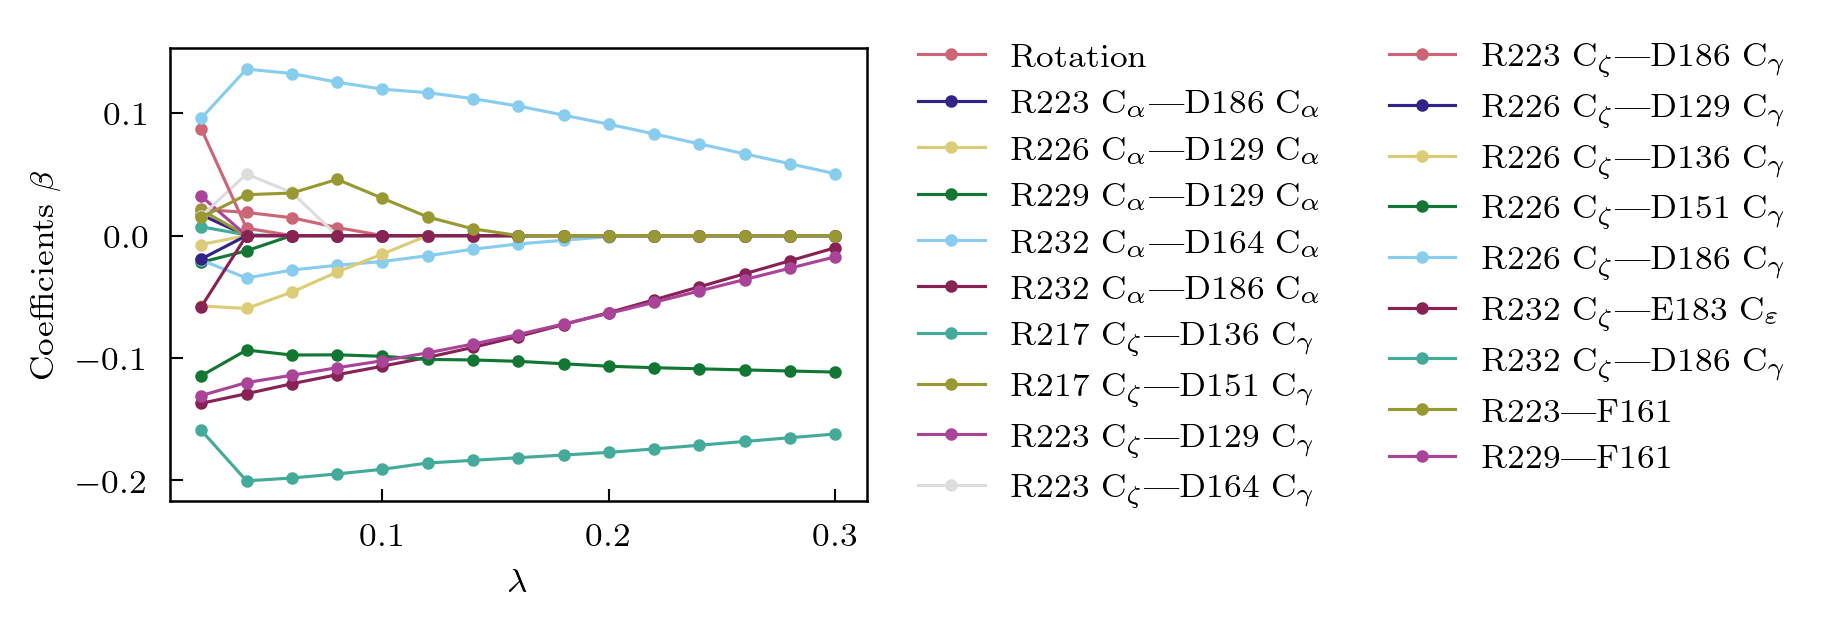

In [37]:
f = plt.figure(figsize=(3, 2), dpi=300)
coeffs_all = np.array(coeffs_all)
alphas = np.linspace(0.02, 0.30, 15)
for i in coeffs_all[0].nonzero()[0]:
    plt.plot(alphas, coeffs_all[:, i], '-o', label=feature_names[i])

pplt.legend(ncol=2, outside='right')
plt.xlabel("$\\lambda$")
plt.ylabel("Coefficients $\\beta$")

In [46]:
coeffs_all = []
r2_all = []
for a in np.linspace(0.05, 0.5, 10):
    print(f"{a:.2f}")
    _, coeffs, _, r2 = run_lasso(X_trans, logit_q, alpha=a, fit_intercept=False)
    coeffs_all.append(coeffs)
    r2_all.append(r2)

0.05
0.10
0.15
0.20
0.25
0.30
0.35
0.40
0.45
0.50


(0.0, 1.0)

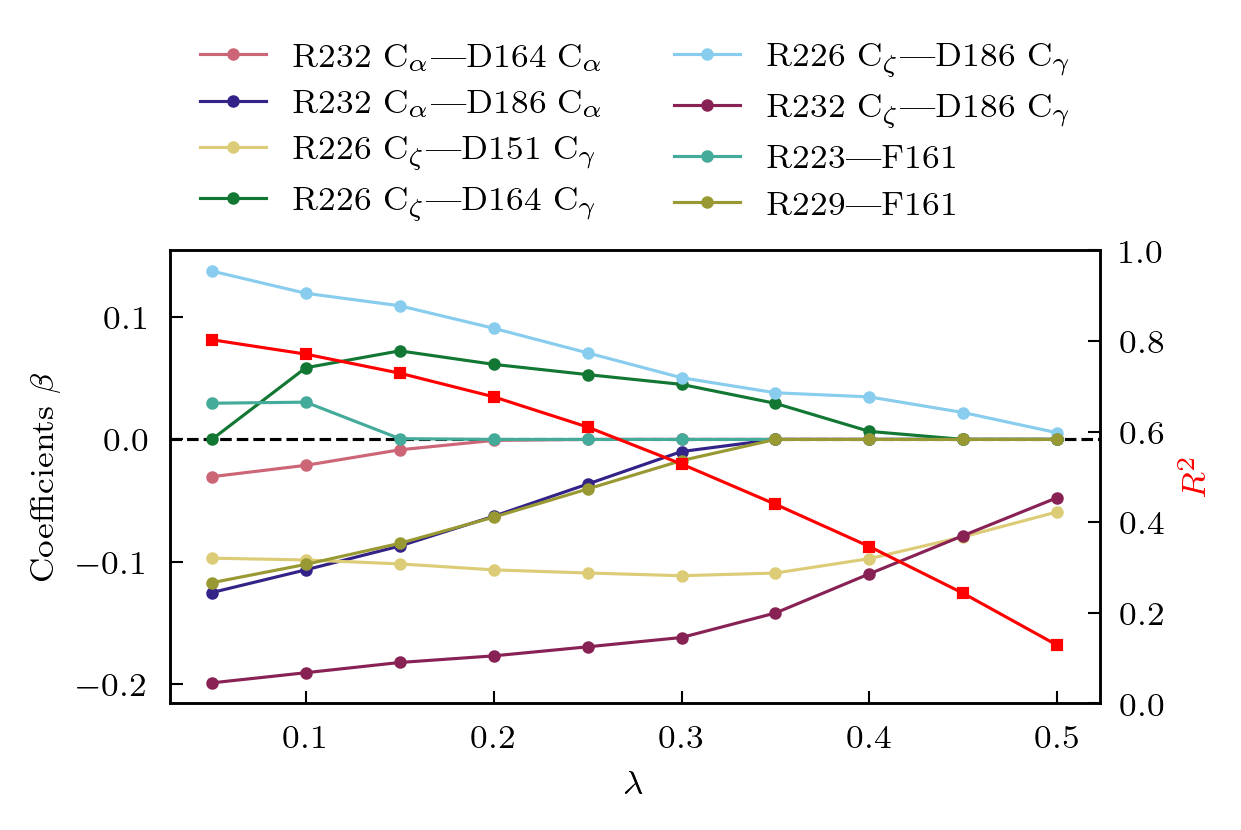

In [52]:
f = plt.figure(figsize=(4, 2), dpi=300)
coeffs_all = np.array(coeffs_all)
alphas = np.linspace(0.05, 0.50, 10)
for i in coeffs_all[2].nonzero()[0]:
    plt.plot(alphas, coeffs_all[:, i], '-o', label=feature_names[i])
plt.xlabel("$\\lambda$")
plt.ylabel("Coefficients $\\beta$")
plt.axhline(ls="--", color='black', zorder=0)
pplt.legend(ncol=2, outside='top')

ax2 = plt.twinx()
ax2.plot(alphas, r2_all, '-s', color='r')
ax2.set_ylabel("$R^2$", color='r')
ax2.set_ylim([0.0, 1.0])

R232 C$_\alpha$—D164 C$_\alpha$: -0.008497167024812914
R232 C$_\alpha$—D186 C$_\alpha$: -0.08725767721633378
R226 C$_\zeta$—D151 C$_\gamma$: -0.10184665443126327
R226 C$_\zeta$—D164 C$_\gamma$: 0.07248304468890611
R226 C$_\zeta$—D186 C$_\gamma$: 0.10938544350346656
R232 C$_\zeta$—D186 C$_\gamma$: -0.18254072928297174
R223—F161: 0.000638130565436232
R229—F161: -0.08504156553216154


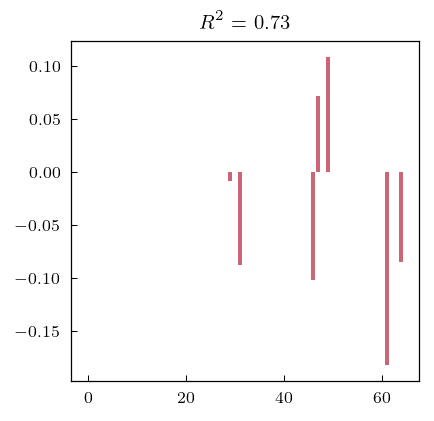

In [54]:
# 0.15 : 7 nonzero coeffs
pred, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=0.15, fit_intercept=False)
plt.bar(np.arange(len(coeffs)), coeffs)
plt.title(f"$R^2$ = {r2:.2f}")
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

# Correlation matrix

In [78]:
import scipy.stats

In [94]:
data = np.hstack((cv_arr, sb_arr[:, 30:], rf161_arr))
corr = np.corrcoef(data.T)

In [95]:
corr.shape

(35, 35)

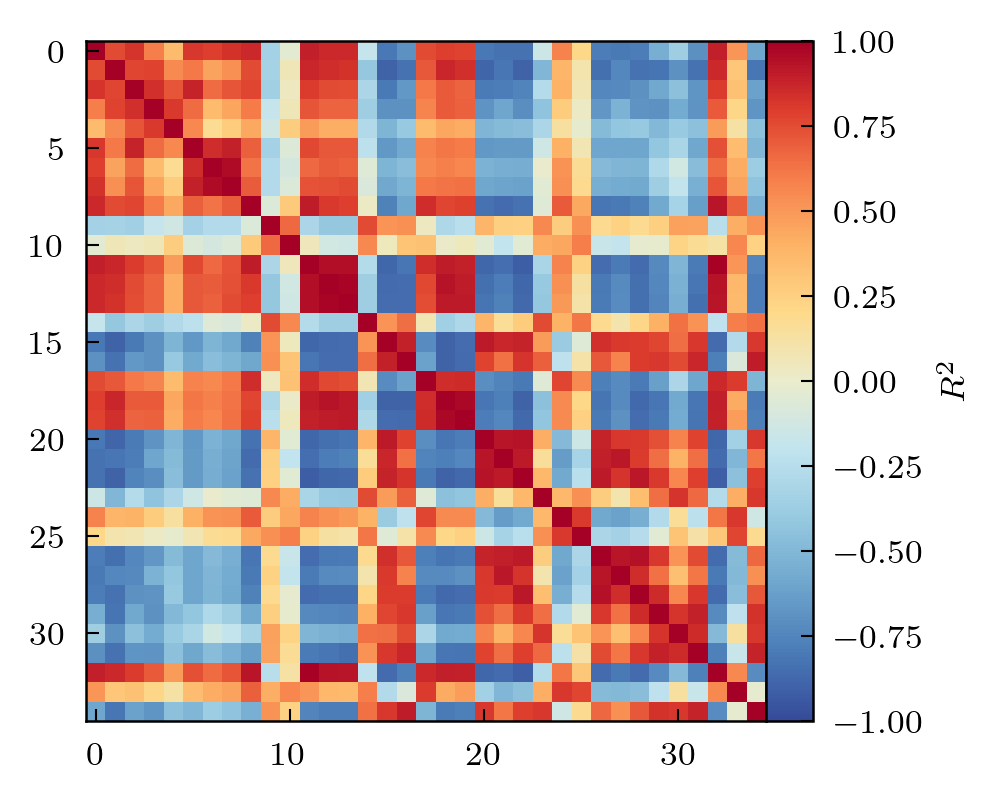

In [96]:
f = plt.figure(dpi=300)
im = pplt.imshow(corr, cmap='diverging', vmin=-1, vmax=1)
pplt.colorbar(im, label="$R^2$")

In [55]:
mid_idx = ((y > cutoff) & (y < 1 - cutoff)).nonzero()[0]
corr = np.corrcoef(X[mid_idx].T)

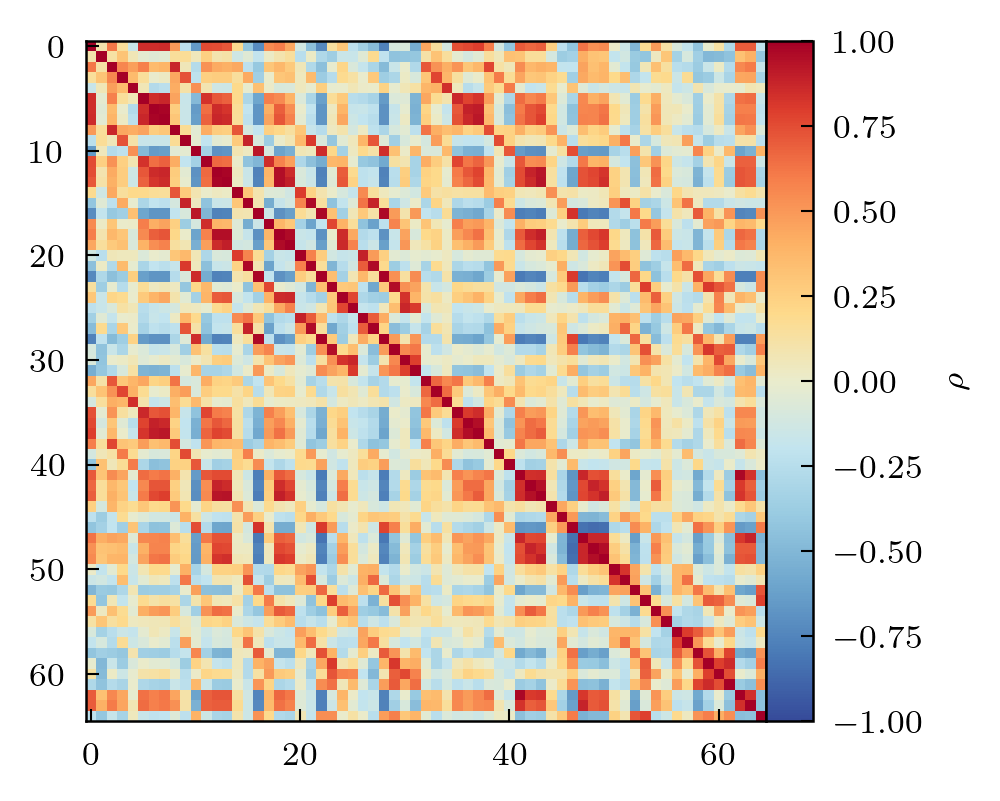

In [56]:
f = plt.figure(dpi=300)
im = pplt.imshow(corr, cmap='diverging', vmin=-1, vmax=1)
pplt.colorbar(im, label="$\\rho$")

In [111]:
from scipy.stats import pearsonr

In [113]:
corr_q = []
for i in range(35):
    corr_q.append(pearsonr(data[:,i], y)[0])

Text(0, 0.5, '$R$')

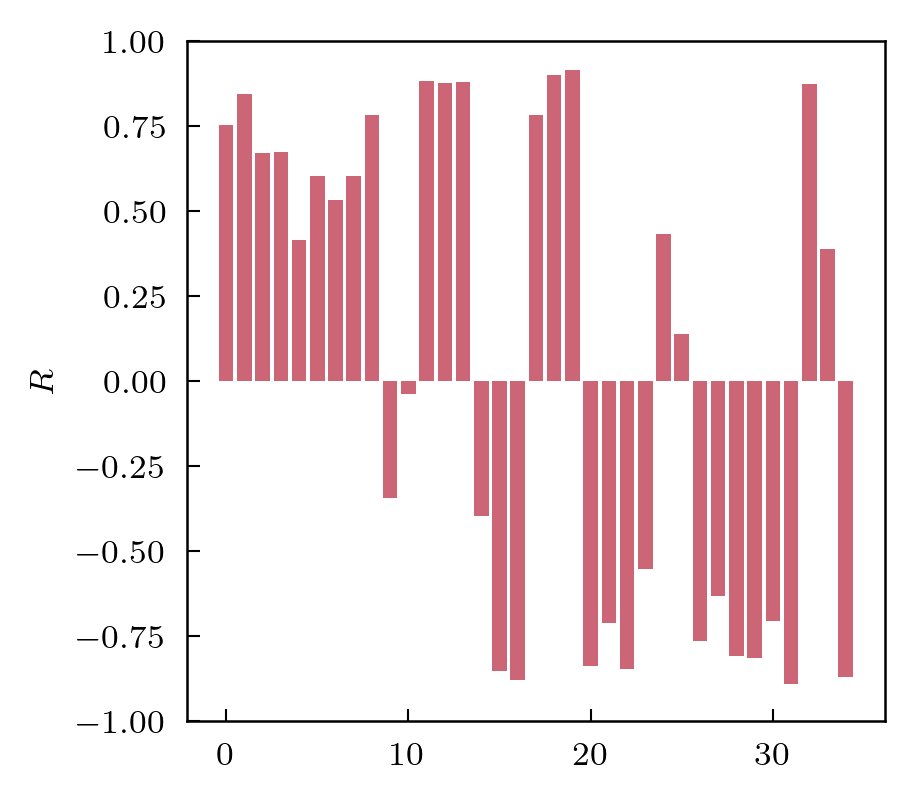

In [115]:
f = plt.figure(dpi=300)
plt.bar(np.arange(35), np.array(corr_q))
plt.ylim([-1, 1])
plt.ylabel("$R$")